In [ ]:
import torch
!pip uninstall torch-geometric torch-cluster  --y
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
%%capture
!pip install scikit-image
import torch_cluster

## Taking only part of total images

In [8]:
!pip install gdown
import gdown
import gdown
import zipfile
import os
url = 'https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr'
output_path = 'large_file.hdf5'
gdown.download(url, output_path, quiet=False)
import matplotlib.pyplot as plt
import numpy as np
import h5py
with h5py.File('large_file.hdf5', 'r') as file:
    train_imgs = np.array(file['X_jets'][:4096])
    test_imgs = np.array(file['X_jets'][4096:4096+1024])
    train_labels = np.array(file['y'][:4096])
    test_labels = np.array(file['y'][4096:4096+1024])
    print(train_imgs[0].shape)

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
import os
import numpy as np
from PIL import Image
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GraphConv, TopKPooling, global_mean_pool
from torch.nn import Linear, BatchNorm1d, ReLU
from torch_geometric.nn import knn_graph
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(

torch.Size([64, 3, 16, 16])
torch.Size([64])


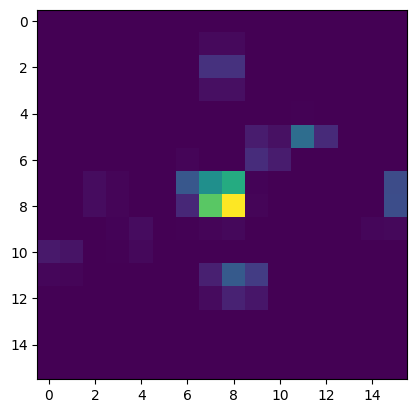

In [6]:
class myData(torch.utils.data.Dataset):
    def __init__(self,imgs,labels):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((16, 16))
            #transforms.Normalize([0.,0.,0.],[1.,1.,1.]),
        ])
        self.imgs = imgs
        self.labels = labels
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        img = self.transform(self.imgs[idx])
        return img,torch.tensor(self.labels[idx]).to(torch.long)

train_loader = torch.utils.data.DataLoader(myData(train_imgs,train_labels), batch_size=64)
val_loader = torch.utils.data.DataLoader(myData(test_imgs,test_labels), batch_size=64)

for imgs,labels in train_loader:
    print(imgs.shape)
    img = imgs[0]
    plt.imshow(img.permute(1,2,0).cpu().numpy()[:,:,2])
    print(labels.shape)
    break

## GNN Model for Classification

In [11]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from skimage.transform import resize

##resizing for efficient processing
train_imgs = [resize(img, (32, 32)) for img in train_imgs[:512*2]]
test_imgs = [resize(img, (32, 32)) for img in test_imgs[:128]]

# Helper function to convert image to point cloud
def image_to_point_cloud(image, label):
    height, width, c = image.shape
    points = []
    for y in range(height):
        for x in range(width):
            points.append([x, y, image[y, x][0],image[y, x][1],image[y, x][2]])  # (x, y, intensity)
    points = np.array(points)
    x = torch.tensor(points, dtype=torch.float)
    y = torch.tensor([label]).to(torch.long)
    edge_index = knn_graph(x, k=8, batch=None, loop=False, flow='source_to_target')##knn graph for edges from point cloud
    return Data(x=x, y=y, edge_index=edge_index)

# Load and preprocess data
train_data = []
test_data = []
for idx,img in enumerate(train_imgs[:512*2]):
    label = train_labels[idx]
    img = img
    data = image_to_point_cloud(img, label)
    train_data.append(data)

for idx,img in enumerate(test_imgs[:32]):
    label = test_labels[idx]
    img = img
    data = image_to_point_cloud(img, label)
    test_data.append(data)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define GNN model
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GraphConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels // 2)
        self.lin2 = Linear(hidden_channels // 2, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Use global mean pooling
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

# Initialize model, optimizer, and loss function
model = GNNModel(5, 64, num_classes=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

# Test loop
def test():
    model.eval()
    correct = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(test_loader.dataset)

accuracies = []
# Train and test model
for epoch in range(20):
    train()
    acc = test()
    accuracies.append(acc)
    print(f'Epoch: {epoch:03d}, Accuracy: {acc:.4f}')

Epoch: 000, Accuracy: 0.4688
Epoch: 001, Accuracy: 0.4688
Epoch: 002, Accuracy: 0.4688
Epoch: 003, Accuracy: 0.4688
Epoch: 004, Accuracy: 0.4688
Epoch: 005, Accuracy: 0.4688
Epoch: 006, Accuracy: 0.5312
Epoch: 007, Accuracy: 0.5312
Epoch: 008, Accuracy: 0.5312
Epoch: 009, Accuracy: 0.4688
Epoch: 010, Accuracy: 0.5312
Epoch: 011, Accuracy: 0.5312
Epoch: 012, Accuracy: 0.4688
Epoch: 013, Accuracy: 0.5312
Epoch: 014, Accuracy: 0.5312
Epoch: 015, Accuracy: 0.5312
Epoch: 016, Accuracy: 0.5312
Epoch: 017, Accuracy: 0.4688
Epoch: 018, Accuracy: 0.4688
Epoch: 019, Accuracy: 0.4688


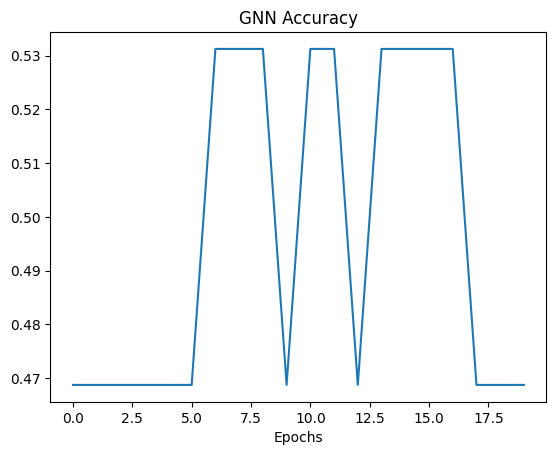

In [17]:
plt.plot(accuracies)
plt.title("GNN Accuracy")
plt.xlabel("Epochs")
plt.show()